Will and Shawn try coding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Estimating constants
Mass ~ 0.035kg if we assume the density is [http://www.advancedmagnets.com/custom-magnets/]

## Create Model

In [64]:
class State:
    def __init__(self, t, x_meas, x, x_dot, x_ddot, v, i_gain):
        self.t = t
        self.x_meas = x_meas
        self.x = x            # Position
        self.x_dot = x_dot    # Velocity
        self.x_ddot = x_ddot  # Acceleration
        self.v = v            # Voltage across solenoid
        self.i_gain = i_gain  # Cumulative error
        
    def get_df(self):
        '''
        Turns state in to a pandas dataframe
        '''
        df = pd.DataFrame({
            't':[self.t],
            'x_meas':[self.x_meas],
            'x':[self.x],
            'x_dot':[self.x_dot],
            'x_ddot':[self.x_ddot],
            'v':[self.v],
            'i_gain':[self.i_gain],
        })
        return df
    
    
def update_x_ddot(State):
    # Force depends on m*g, voltage across solenoid, position of permanent magnet
    force = m*g - cf * State.v / (State.x**2)
    # Calculate acceleration using force
    x_ddot = force / m
    return x_ddot

def update_x_dot(State):
    # Calculate change in velocity with acceleration * time
    x_dot = State.x_ddot * delta_t + State.x_dot
    return x_dot

def update_x(State):
    # Calculate change in position with velocity * time
    x = State.x_dot * delta_t + State.x
    return x

def update_v(State):
    '''
    This is our controller
    '''
    error = (State.x - target)
    
    p_gain = kp * error
    
    d_gain = kd * State.x_dot
    i_gain = State.i_gain + ki*error*delta_t
    
    new = p_gain + d_gain + i_gain
    
    return new, i_gain

def update_state(previous):
    '''
    Takes in a state, calculates an updated state using functions defined above
    '''
    t = previous.t + delta_t
    x_ddot = update_x_ddot(previous)
    x_dot = update_x_dot(previous)
    x = update_x(previous)
    x_meas = x
    v, i_gain = update_v(previous)
    new_vals = [t, x_meas, x, x_dot, x_ddot, v, i_gain]
    new_state = State(*new_vals)
    return new_state

def run_sim(initial_state, duration):    
    time = 0

    state = initial_state
    
    df = pd.DataFrame()
    
    while time < duration:
        df = df.append(state.get_df())
        
        new_state = update_state(state)
        state = new_state
        time += delta_t

    df = df.set_index('t')
    return df

## Evaluate Model

In [62]:
# Physical constants
g = 9.81 #gravity
m = .1   #mass 
cm = 1  # hall effect sensor mass coefficient
cv = 1   # hall effect sensor solenoid coefficient
cf = 1   # force of solenoid coefficient

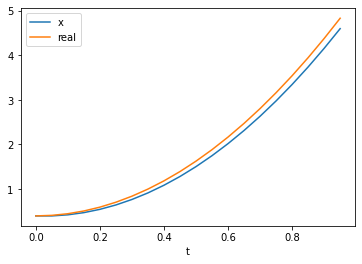

In [167]:
# Input signal and starting position
target =  0.4

# PID controller constants
kp = 0        #proportional constant
kd = 0         #derivative constant
ki = 0       #integral constant

# Simulation properties
delta_t = .05 #time step between points
run_time = 1

initial_state = State(0, target, target, 0, 9.81, 0, 0)
df = run_sim(initial_state, run_time)


time = np.arange(0, run_time, delta_t)
real_pos = .5 * g * time**2 + 0.4



df['x'].plot(label="x")
# df['x_dot'].plot()

plt.plot(time, real_pos, label = "real")
# df['x_ddot'].plot(label="accel")

plt.legend()
# plt.ylim(0,1)

In [157]:
df.head()

,x_meas,x,x_dot,x_ddot,v,i_gain
t,,,,,,
0.000,0.400000,0.400000,0.00000,9.81,0.0,0.0
0.001,0.400000,0.400000,0.00981,9.81,0.0,0.0
0.002,0.400010,0.400010,0.01962,9.81,0.0,0.0
0.003,0.400029,0.400029,0.02943,9.81,0.0,0.0
0.004,0.400059,0.400059,0.03924,9.81,0.0,0.0


<AxesSubplot:xlabel='t'>

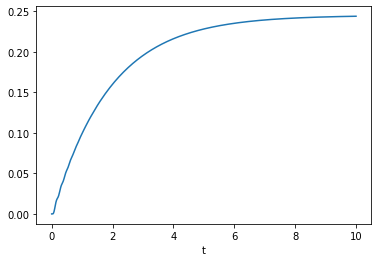

In [40]:
df['i_gain'].plot()